<a href="https://colab.research.google.com/github/atloveu1226/CMIT2024/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
from skimage import io, transform
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [49]:
'/content/your_folder/MyDrive/Colab_Notebooks/DRIVE.zip'

'/content/your_folder/MyDrive/Colab_Notebooks/DRIVE.zip'

In [43]:
!unzip "/content/your_folder/MyDrive/Colab_Notebooks/DRIVE.zip" -d "/content/your_folder/MyDrive/DATA"

Archive:  /content/your_folder/MyDrive/Colab_Notebooks/DRIVE.zip
  inflating: /content/your_folder/MyDrive/DATA/DRIVE/._.DS_Store  
  inflating: /content/your_folder/MyDrive/DATA/DRIVE/.DS_Store  
   creating: /content/your_folder/MyDrive/DATA/DRIVE/test/
  inflating: /content/your_folder/MyDrive/DATA/DRIVE/test/._.DS_Store  
  inflating: /content/your_folder/MyDrive/DATA/DRIVE/test/.DS_Store  
   creating: /content/your_folder/MyDrive/DATA/DRIVE/test/1st_manual/
  inflating: /content/your_folder/MyDrive/DATA/DRIVE/test/1st_manual/._1_manual1.png  
  inflating: /content/your_folder/MyDrive/DATA/DRIVE/test/1st_manual/._9_manual1.png  
 extracting: /content/your_folder/MyDrive/DATA/DRIVE/test/1st_manual/1_manual1.gif  
  inflating: /content/your_folder/MyDrive/DATA/DRIVE/test/1st_manual/1_manual1.png  
 extracting: /content/your_folder/MyDrive/DATA/DRIVE/test/1st_manual/10_manual1.gif  
  inflating: /content/your_folder/MyDrive/DATA/DRIVE/test/1st_manual/10_manual1.png  
 extracting: /co

In [58]:
def get_paths(base_path='/content/your_folder/MyDrive/DATA/DRIVE/'):
    train_im_paths = []
    train_gt_paths = []
    test_im_paths = []
    test_gt_paths = []

    for i in range(21, 41):
        train_im_paths.append(base_path + 'training/images/%d_training.tif'%(i))
        train_gt_paths.append(base_path + 'training/1st_manual/%d_manual1.gif'%(i))

    for i in range(1, 21):
        test_im_paths.append(base_path + 'test/images/%d_test.tif'%(i))
        test_gt_paths.append(base_path + 'test/1st_manual/%d_manual1.gif'%(i))

    train_paths = [train_im_paths,train_gt_paths]
    test_paths = [test_im_paths,test_gt_paths]
    return train_paths, test_paths

In [59]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths):
        # TODO
        # 1. Initialize file paths or a list of file names.
        self.im_paths = paths[0]
        self.gt_paths = paths[1]
        self.preprocesses = T.Compose([
            T.Resize((256,256)),
            T.ToTensor(),
        ])
        pass
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        image = Image.open(self.im_paths[index])
        label = Image.open(self.gt_paths[index])
        # 2. Preprocess the data (e.g. torchvision.Transform).

        image = self.preprocesses(image)
        label = self.preprocesses(label)

        #Ensure gt is binary
        label[label>.5] = 1
        label[label<=.5]=0
        # 3. Return a data pair (e.g. image and label).
        return image, label

    def __len__(self):
        return len(self.im_paths)


train_paths, test_paths = get_paths()

custom_dataset = CustomDataset(train_paths)
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=4,
                                           shuffle=True)


In [60]:
print(train_paths[0])
print(train_paths[1])

['/content/your_folder/MyDrive/DATA/DRIVE/training/images/21_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/22_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/23_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/24_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/25_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/26_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/27_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/28_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/29_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/30_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/31_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/32_training.tif', '/content/your_folder/MyDrive/DATA/DRIVE/training/images/33_training.tif', '/content/your_folder/My

In [61]:
print(train_loader)
data_iter = iter(train_loader)
print(data_iter)

image,label = next(data_iter)
print(image.size())
print(label.size())

label = torch.squeeze(label)
print(label.size())

torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 256, 256])


torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


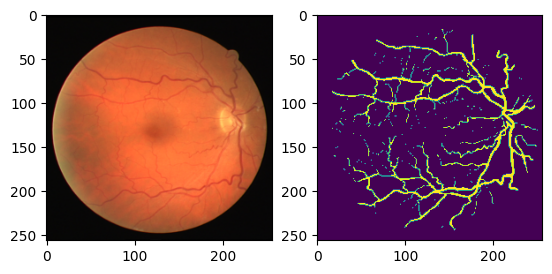

In [62]:
im,label = custom_dataset[1]
print(im.size())
print(label.size())

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im.permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(label[0,:,:])

In [63]:
class CNN(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(CNN, self).__init__()
        f = [10,20,30,20,10,out_channels]
# Input to conv1 will be image of shape [batch_size,1,img_size,img_size]
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=f[0],kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=f[0],out_channels=f[1],kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=f[1],out_channels=f[2],kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=f[2],out_channels=f[2],kernel_size=(3,3),padding=1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=f[2],out_channels=f[3],kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2))

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=f[3],out_channels=f[4],kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2))


        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=f[4],out_channels=f[5],kernel_size=(1,1)),
            nn.Sigmoid()
        )


    def forward(self, x,plot=False):

        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)

        if plot:
            print('Input shape', x.shape)
            print('After layer 1', x1.shape)
            print('After layer 2', x2.shape)
            print('After layer 3', x3.shape)
            print('After layer 4', x4.shape)
            print('After layer 5', x5.shape)
            print('After layer 6', x6.shape)

        return x6

model = CNN(in_channels=3, out_channels=1)

In [64]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        ###comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)

        ###flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice


In [65]:
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_func = DiceLoss()

In [73]:
from torch.autograd import Variable

num_epochs = 600

def train(num_epochs, model, train_loader):

    model.train()

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = model(b_x)
            #loss = loss_func(torch.squeeze(output), torch.squeeze(b_y))
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()                # apply gradients
            optimizer.step()

            if (i+1) % 2 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))



train(num_epochs, model, train_loader)

Epoch [1/600], Step [2/5], Loss: 0.7875
Epoch [1/600], Step [4/5], Loss: 0.7849
Epoch [2/600], Step [2/5], Loss: 0.7694
Epoch [2/600], Step [4/5], Loss: 0.7704
Epoch [3/600], Step [2/5], Loss: 0.7637
Epoch [3/600], Step [4/5], Loss: 0.7832
Epoch [4/600], Step [2/5], Loss: 0.7824
Epoch [4/600], Step [4/5], Loss: 0.7889
Epoch [5/600], Step [2/5], Loss: 0.7765
Epoch [5/600], Step [4/5], Loss: 0.7850
Epoch [6/600], Step [2/5], Loss: 0.7826
Epoch [6/600], Step [4/5], Loss: 0.7656
Epoch [7/600], Step [2/5], Loss: 0.7784
Epoch [7/600], Step [4/5], Loss: 0.7484
Epoch [8/600], Step [2/5], Loss: 0.7724
Epoch [8/600], Step [4/5], Loss: 0.7882
Epoch [9/600], Step [2/5], Loss: 0.7800
Epoch [9/600], Step [4/5], Loss: 0.7932
Epoch [10/600], Step [2/5], Loss: 0.7666
Epoch [10/600], Step [4/5], Loss: 0.7869
Epoch [11/600], Step [2/5], Loss: 0.8040
Epoch [11/600], Step [4/5], Loss: 0.7956
Epoch [12/600], Step [2/5], Loss: 0.7463
Epoch [12/600], Step [4/5], Loss: 0.7992
Epoch [13/600], Step [2/5], Loss: 

This is the model with 800 epoches.

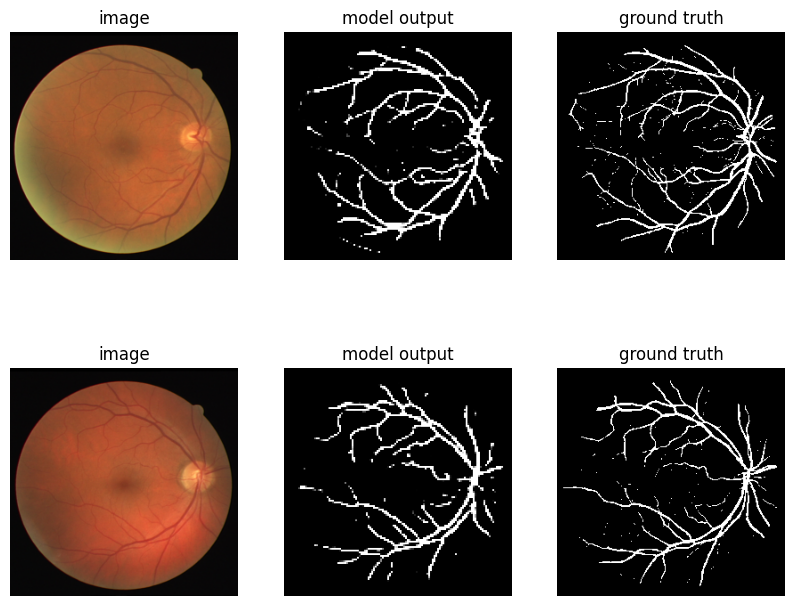

In [74]:
test_dataset = CustomDataset(test_paths)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=4,
                                           shuffle=False)
dataset = test_dataset

with torch.no_grad():
    figure = plt.figure(figsize=(10, 8))
    rows = 2
    for i in range(0, rows):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        b_x = img.unsqueeze(0)
        output = model(b_x)

        figure.add_subplot(rows, 3, 3*i + 1)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
        plt.title("image")
        figure.add_subplot(rows, 3, 3*i + 2)
        plt.axis("off")
        plt.imshow(torch.squeeze(output), cmap="gray")
        plt.title("model output")
        figure.add_subplot(rows, 3, 3*i + 3)
        plt.axis("off")
        plt.imshow(torch.squeeze(label), cmap="gray")
        plt.title("ground truth")
    plt.show()